# Volumetry Analysis
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32), will expand to PPMI and ADNI NC after QCed.

## Tasks
- Compare total cerebellar volumes (left and right)
- Compare lobule volumes (13 per hemisphere)

## Covariates
- Age, Sex, site, eTIV

In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
mni_file  = data_dir/'MNI_Des-cere_preped.csv'
adni_ppmi_file = data_dir/'ADNI-PPMI_Des-cere_preped.csv'

mni_df       = pd.read_csv(mni_file , sep=',', header=0, index_col=0);
adni_ppmi_df = pd.read_csv(adni_ppmi_file , sep=',', header=0, index_col=0);

#excluding list
data_df = pd.concat([mni_df, adni_ppmi_df])
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
data_df=data_df.drop(columns=drop_col_list);

In [2]:
SUIT_labels = ['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
analysis_list = []

ET 38
NC 32


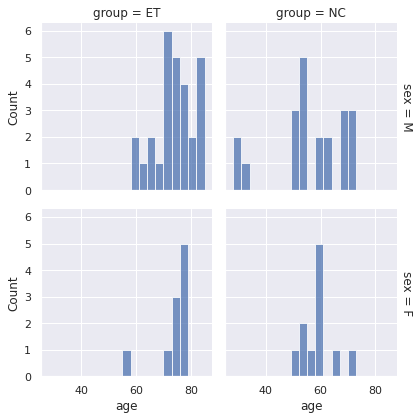

In [7]:
#plot age/sex/diagnosis distributions 2*3
for x in GROUPS:
    print(x , len(mni_df[mni_df["group"]==x]))
sns.set_theme(style="darkgrid")
sns.displot(
    mni_df, x="age", col="group", row="sex", 
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))

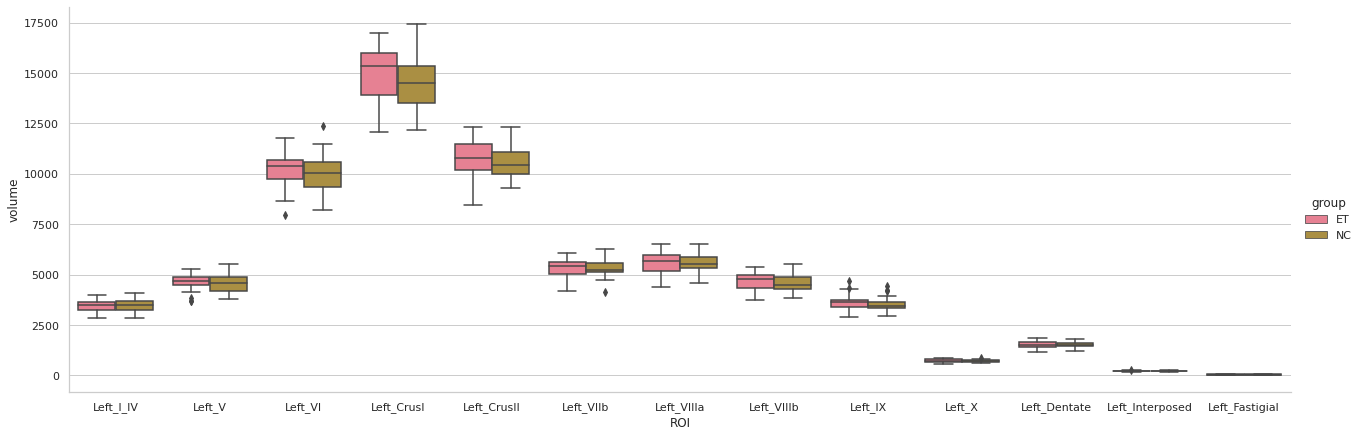

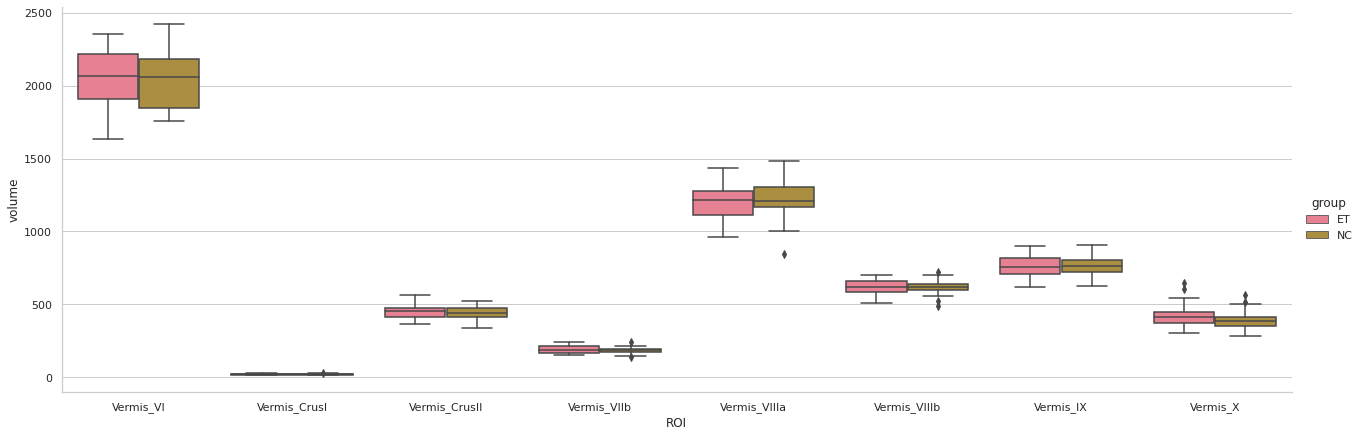

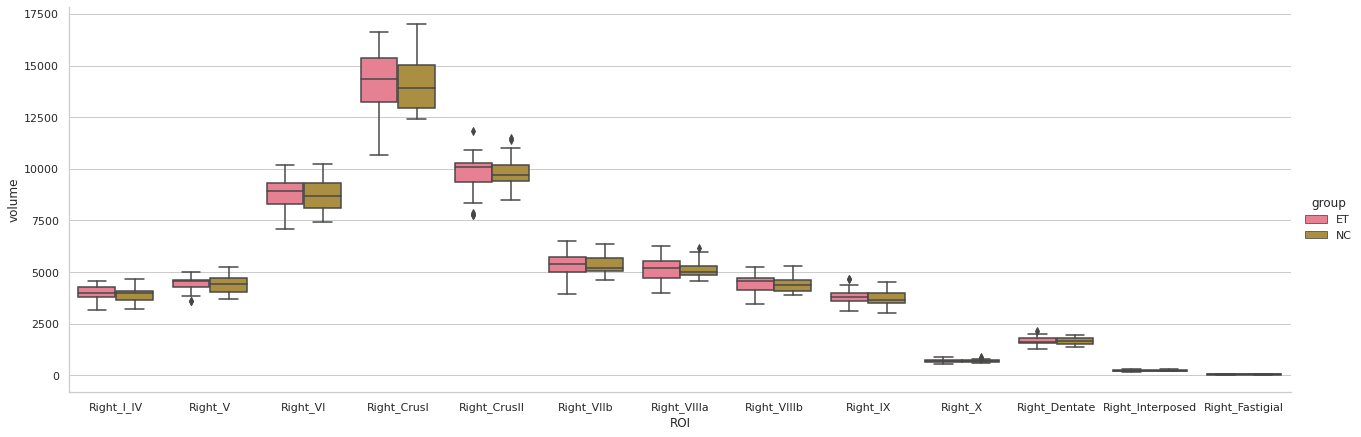

In [12]:
# SUIT lobule results vis
sns.set(font_scale=1)
vis_suit_df=mni_df.copy()
vis_suit_df['participant_id']=vis_suit_df.index
palette = sns.color_palette('husl', 6)
with sns.axes_style("whitegrid"):
    plot_l_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_l_labels, 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_l_df)
    plot_v_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_v_labels, 
                      var_name ='ROI', value_name ='volume')
    g1 = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_v_df)
    plot_r_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_r_labels, 
                      var_name ='ROI', value_name ='volume')
    g2 = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_r_df)

In [8]:
# prepare target data
from matching.utils import sum_lr, ctr_age, ctr_conf, glm_test, sts_test, reformat_df
g_var_list  = ['age', 'sex', 'diagnosis', 'eTIV'];
s_var_list  = ['BrainSegVol','CSF','CerebralWhiteMatterVol','CortexVol', 'Brain_Stem', 'SubCortGrayVol', 'TotalGrayVol',
               'CC_Anterior','CC_Mid_Anterior','CC_Central','CC_Mid_Posterior','CC_Posterior',
               '3rd_Ventricle','4th_Ventricle','SupraTentorialVol'];
lr_var_list = ['Cerebellum_Cortex','Cerebellum_White_Matter',
               'Accumbens_area', 'Amygdala','Hippocampus',
               'Caudate', 'Pallidum', 'Putamen', 'Thalamus_Proper', 
               'Inf_Lat_Vent','Lateral_Ventricle'];
curr_data, curr_lr_list = sum_lr(tab_data, lr_var_list);
tab_data.columns

ModuleNotFoundError: No module named 'matching'

In [3]:
target_list = ['CSF','CerebralWhiteMatterVol','CortexVol', 'TotalGrayVol',
               'Brain_Stem', 'SubCortGrayVol', 
               'Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
               'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
               'Cerebellum_Cortex','Cerebellum_White_Matter'];columns

In [6]:
### 
curr_data['infratentorial']=curr_data['eTIV']-curr_data['SupraTentorialVol'];

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from scipy.stats import ranksums
import pandas as pd
import numpy as np

n_permu=10000; alpha=5;
stats_cols = ['voi','group','cohen_d','cohen_p','Wilcoxon','Wilcoxon_p','method'];
#[x for x in curr_data.columns if 'tent' in x.lower()]

In [7]:
## covariate
sub_err  = [x for x in curr_data.index if curr_data.loc[x,'Left_I_IV']<1000];
tab_data = curr_data.drop(index = sub_err); # super large head normal control, NC
mdtb_labels = ['MDTB_'+str(x+1) for x in range(10)];

suit_labels = ['Left_I_IV', 'Right_I_IV', 'Left_V', 'Right_V', 'Left_VI', 'Vermis_VI',
               'Right_VI', 'Left_CrusI', 'Vermis_CrusI', 'Right_CrusI', 'Left_CrusII',
               'Vermis_CrusII', 'Right_CrusII', 'Left_VIIb', 'Vermis_VIIb',
               'Right_VIIb', 'Left_VIIIa', 'Vermis_VIIIa', 'Right_VIIIa', 'Left_VIIIb',
               'Vermis_VIIIb', 'Right_VIIIb', 'Left_IX', 'Vermis_IX', 'Right_IX',
               'Left_X', 'Vermis_X', 'Right_X', 'Left_Dentate', 'Right_Dentate',
               'Left_Interposed', 'Right_Interposed', 'Left_Fastigial','Right_Fastigial'];

tar_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
            'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
            'Cerebellum_Cortex','Cerebellum_White_Matter']+suit_labels+mdtb_labels;

tab_data, rm_norm_list, rm_norm_reg = ctr_conf(
    tab_data, ['age', 'is_Male', 'infratentorial'], tar_list, 'rm_norm');
tab_data, pcp_list, pcp_reg = ctr_conf(tab_data, 'infratentorial', tar_list, 'ppa');
tab_data, dpa_list = ctr_conf(tab_data, 'infratentorial', tar_list, 'dpa');
tab_data, asm_list, asm_reg = ctr_conf(tab_data, 'infratentorial', tar_list, 'asm');
tab_data, rm_list, rm_reg = ctr_conf(tab_data, 'infratentorial', tar_list, 'rm_mean');


# 'Cerebellum_Cortex','Cerebellum_White_Matter',
covariate_model_str = '~age+sex+infratentorial+C(diagnosis, Treatment(reference="NC"))';
covariate_dict = glm_test(tab_data, tar_list, covariate_model_str);
covariate_df=sts_test(tar_list, tab_data, stats_cols, alpha, n_permu, 'covariate')
## dpa
dpa_list = [x+"_dpa" for x in tar_list ];
dpa_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
dpa_dict = glm_test(tab_data, dpa_list, dpa_model_str);
dpa_df=sts_test(dpa_list, tab_data, stats_cols, alpha, n_permu, 'dpa');
## ppa
ppa_list = [x+"_ppa" for x in tar_list ];
ppa_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
ppa_dict = glm_test(tab_data, ppa_list, ppa_model_str);
ppa_df=sts_test(ppa_list, tab_data, stats_cols, alpha, n_permu, 'ppa');
## rm_norm
rm_norm_list = [x+"_rm_norm" for x in tar_list ];
rm_norm_model_str = '~C(diagnosis, Treatment(reference="NC"))';
rm_norm_dict = glm_test(tab_data, rm_norm_list, rm_norm_model_str);
rm_norm_df=sts_test(rm_norm_list, tab_data, stats_cols, alpha, n_permu, 'rm_norm');
## rm_mean
rm_mean_list = [x+"_rm_mean" for x in tar_list];
rm_mean_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
rm_mean_dict = glm_test(tab_data, rm_mean_list, rm_mean_model_str);
rm_mean_df=sts_test(rm_mean_list, tab_data, stats_cols, alpha, n_permu, 'rm_mean');
## asm
asm_list = [x+"_asm" for x in tar_list];
asm_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
asm_dict = glm_test(tab_data, asm_list, asm_model_str);
asm_df   = sts_test(asm_list, tab_data, stats_cols, alpha, n_permu, 'asm');

In [14]:
from matching.utils import reformat_df
from matching.vis import heatmap, annotate_heatmap

sts_df = pd.DataFrame();
sts_df = sts_df.append(covariate_df.append(ppa_df.append(rm_norm_df.append(rm_mean_df.append(asm_df.append(dpa_df, ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True)

et_es, et_p, p_multi_et, voi_name, method_name = reformat_df(sts_df, 'ETNC', ['cohen_d', 'cohen_p']);
pd_es, pd_p, p_multi_pd, voi_name, method_name = reformat_df(sts_df, 'PDNC', ['cohen_d', 'cohen_p']);

et_wil, et_wp, wp_multi_et, voi_name, method_name = reformat_df(sts_df, 'ETNC', ['Wilcoxon', 'Wilcoxon_p']);
pd_wil, pd_wp, wp_multi_pd, voi_name, method_name = reformat_df(sts_df, 'PDNC', ['Wilcoxon', 'Wilcoxon_p']);

#method_name = ['Voi','DPA','PPA','RM-Norm', 'RM-Mean','Allometric Scaling']

import numpy as np
import matplotlib.pyplot as plt
def plot_effectsize(et_es, et_p, p_multi_et, NAME):
    #et_es=et_es[0]; et_p=et_p[0]; p_multi_et=p_multi_et[0];
    import matplotlib.pyplot as plt
    VMIN = 0; VMAX=0.1; C_MAP='coolwarm_r'; es_th = 0.2; f_size=[7,8];
    fig1=plt.figure(figsize=f_size); ax1 = fig1.subplots();
    im1, cbar1 = heatmap(np.array(et_p), method_name, voi_name, ax=ax1, cmap=C_MAP, cbarlabel="$p$  value", vmin=VMIN, vmax=VMAX)
    #texts = annotate_heatmap(im1, np.array(et_es), valfmt="{x:.4f}", textcolors=["grey", "black"], threshold=es_th)
    ax1.set_title(NAME); fig1.tight_layout(); plt.show()
    fig2=plt.figure(figsize=f_size); ax2 = fig2.subplots();
    im2, cbar2 = heatmap(np.array(p_multi_et), method_name, voi_name, ax=ax2, cmap=C_MAP,cbarlabel="$p$  value", vmin=VMIN, vmax=VMAX)
    #texts = annotate_heatmap(im2, np.array(et_es), valfmt="{x:.4f}", textcolors=["grey", "black"], threshold=es_th)
    ax2.set_title(NAME+' (with BH correction)'); fig2.tight_layout(); plt.show()
    return ax1, ax2

ax1_et_coh, ax2_et_coh = plot_effectsize(et_es, et_p, p_multi_et, 'Cohen $d$ for comparing ET and NC group')
ax1_pd_coh, ax2_pd_coh = plot_effectsize(pd_es, pd_p, p_multi_pd, 'Cohen $d$ for comparing PD and NC group')
ax1_et_wil, ax2_et_wil = plot_effectsize(et_wil, et_wp, wp_multi_et, 'Wilcoxon signed-rank for comparing ET and NC group')
ax1_pd_wil, ax2_pd_wil = plot_effectsize(pd_wil, pd_wp, wp_multi_pd, 'Wilcoxon signed-rank for comparing PD and NC group')


ImportError: cannot import name 'reformat_df' from 'matching.utils' (/codes/matching/utils.py)

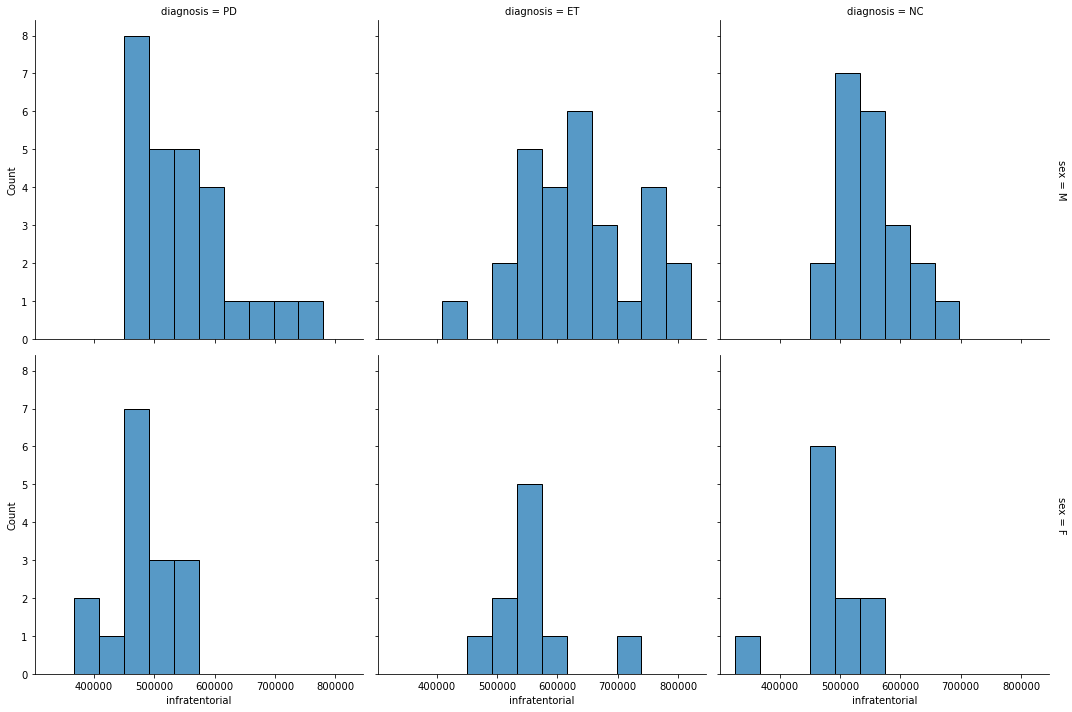

In [11]:
import seaborn as sns
sns.displot(
    curr_data, x="infratentorial", col="diagnosis", row="sex", facet_kws=dict(margin_titles=True))

In [12]:
mdtb_labels = ['MDTB_'+str(x+1) for x in range(10)];
suit_labels = ['Left_I_IV', 'Right_I_IV', 'Left_V', 'Right_V', 'Left_VI', 'Vermis_VI',
               'Right_VI', 'Left_CrusI', 'Vermis_CrusI', 'Right_CrusI', 'Left_CrusII',
               'Vermis_CrusII', 'Right_CrusII', 'Left_VIIb', 'Vermis_VIIb',
               'Right_VIIb', 'Left_VIIIa', 'Vermis_VIIIa', 'Right_VIIIa', 'Left_VIIIb',
               'Vermis_VIIIb', 'Right_VIIIb', 'Left_IX', 'Vermis_IX', 'Right_IX',
               'Left_X', 'Vermis_X', 'Right_X', 'Left_Dentate', 'Right_Dentate',
               'Left_Interposed', 'Right_Interposed', 'Left_Fastigial','Right_Fastigial'];